In [1]:
from pylab import * 
%matplotlib inline

# Big Data Analysis with Apache Spark

![](spark-logo.png)

Advantages:
* distributed, in-memory
* (almost) arbitrary sources (flatfile, json, ODBC/JDBC data source, ...)
* use from python/R/Java/...
* Use SQL or write complex map-reduce tasks in the programming language of choice (-> machine learning) 


## 1. Setup the cluster
see http://hpcportal.roche.com/documentation/hpc-resources/show/7224119760665747911

Essentially: 
```bash
ssh hpclogin.bas.roche.com
ml load Spark-pREDi
ml load Spark/2.1.0
sbatch spark-launch.sh
```

starts a 5-node spark cluster with 1.2TB of memory. 

Inspect the `slurm-*.out` file to get the URL. 

## 2. Access the cluster from Jupyter

In [2]:
import findspark
findspark.init("/pstore/apps/Spark/2.1.0/")

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from utils import *

In [4]:
conf = SparkConf()
# conf.setMaster("spark://rkalbhpc024:43925")

In [5]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [6]:
sc.master

'local[*]'

## 3. Example: get median of liver genes across all tissues

### Get the liver genes from a `gmt` file

In [7]:
from pygenesig.file_formats import read_gmt

In [8]:
signatures = read_gmt("/pstore/home/sturmg/projects/pygenesig-example/results/gtex_v6_solid_gini_0.8_1/signatures.gmt")

In [9]:
liver_genes = signatures["Liver"]

### Load the gene expression data

In [34]:
!ls -lh /pstore/data/bioinfo/users/sturmg/genecrunch/melt_geo/

total 417G
-rw-rw---- 1 sturmg bioinfo  53G Apr 20 17:52 geo_all_82k.uniq.tsv
-rw-rw---- 1 sturmg bioinfo 240G Apr 21 08:58 geo_all.tsv
drwxrws--- 3 sturmg bioinfo 4.0K Apr 26 11:38 geo_all.uniq.parquet
-rw-rw---- 1 sturmg bioinfo 125G Apr 21 14:14 geo_all.uniq.tsv
-rw-rw---- 1 sturmg bioinfo  52K Apr 20 15:37 gse_list_bioqc_geo.txt
-rw-rw---- 1 sturmg bioinfo 129K Apr 20 14:51 gse_list.txt
-rw-rw---- 1 sturmg bioinfo   51 Apr 21 08:51 missing_esets.txt
-rw-rw---- 1 sturmg bioinfo 129K Apr 21 08:51 molten_esets.txt
drwxrws--- 2 sturmg bioinfo 512K Apr 21 08:48 out
-rw-rw---- 1 sturmg bioinfo 9.0M Apr 26 14:10 test.tsv
-rw-rw---- 1 sturmg bioinfo    0 Apr 21 08:51 todo.txt


In [45]:
!head /pstore/data/bioinfo/users/sturmg/genecrunch/melt_geo/test.tsv

GSM1001158	A1CF	6.53	14263.5
GSM1001158	A2M	5.73	18037.5
GSM1001158	A4GALT	3.64	29593
GSM1001158	A4GNT	5.1	21455
GSM1001158	AAAS	7.09	11936.5
GSM1001158	AACS	8.34	7131.5
GSM1001158	AADAC	13.07	263.5
GSM1001158	AADAT	11.11	1390.5
GSM1001158	AAED1	8.47	6686
GSM1001158	AAGAB	8.06	8132.5


In [46]:
df_signals = sqlContext.read.format('com.databricks.spark.csv').options(
    header='false', delimiter='\t', nullValue='NA'
).load("/pstore/data/bioinfo/users/sturmg/genecrunch/melt_geo/test.tsv", schema=schema_signals)

### Two ways to achieve the same thing: Using SQL...

In [50]:
df_liver_genes = sqlContext.createDataFrame([(x,) for x in liver_genes], ['hgnc'])

In [51]:
df_signals.createOrReplaceTempView("signals")
df_liver_genes.createOrReplaceTempView("liver_genes")

In [95]:
df_liver = sqlContext.sql("""
select signals.gsm
     , percentile_approx(expr, .5) as median_expression
from signals
join liver_genes
  on liver_genes.hgnc = signals.hgnc
group by signals.gsm 
order by signals.gsm
""")
df_liver.createOrReplaceTempView("liver")

In [96]:
df_liver.show()

+----------+------------------+
|       gsm| median_expression|
+----------+------------------+
|GSM1001158|11.260000228881836|
|GSM1001159|  11.3100004196167|
|GSM1001160|11.199999809265137|
|GSM1001161|11.470000267028809|
|GSM1001162|  11.3100004196167|
|GSM1001163|11.260000228881836|
|GSM1001164|11.390000343322754|
|GSM1001165|11.319999694824219|
|GSM1001166|11.420000076293945|
|GSM1001167|11.289999961853027|
|GSM1001302| 10.39603042602539|
|GSM1001303| 10.29699993133545|
|GSM1001304|10.438407897949219|
|GSM1001305| 10.43532943725586|
|GSM1001306|10.572232246398926|
|GSM1001307|10.425337791442871|
|GSM1001308|10.550618171691895|
|GSM1001309|10.604266166687012|
|GSM1001498| 4.124630928039551|
|GSM1001499|3.9983859062194824|
+----------+------------------+
only showing top 20 rows



### or using python

In [43]:
import numpy as np

In [103]:
df_liver_py = df_signals.rdd.filter(lambda row: row['hgnc'] in liver_genes) \
                            .groupBy(lambda r: r['gsm']) \
                            .mapValues( lambda g: np.median([x['expr'] for x in g])) \
                            .sortByKey()

In [107]:
df_liver_py.take(10)

[('GSM1001158', 11.260000228881836),
 ('GSM1001159', 11.330000400543213),
 ('GSM1001160', 11.199999809265137),
 ('GSM1001161', 11.470000267028809),
 ('GSM1001162', 11.310000419616699),
 ('GSM1001163', 11.285000324249268),
 ('GSM1001164', 11.400000095367432),
 ('GSM1001165', 11.324999809265137),
 ('GSM1001166', 11.434999942779541),
 ('GSM1001167', 11.304999828338623)]

## complement this with the 'platform' information. 

In [115]:
df_meta = sqlContext.read.parquet('/pstore/data/bioinfo/users/sturmg/genecrunch/geometa.parquet/')
df_meta.createOrReplaceTempView("meta")

In [117]:
df_liver_me = sqlContext.sql("""
select distinct liver.*
              , meta.gpl
from liver
join meta
  on meta.gsm = liver.gsm
""")

In [118]:
liver_median.show(4)

+----------+------------------+--------+
|       gsm| median_expression|     gpl|
+----------+------------------+--------+
|GSM1001166|11.420000076293945| GPL1261|
|GSM1001166|11.420000076293945|GPL11002|
|GSM1001166|11.420000076293945|GPL16144|
|GSM1001166|11.420000076293945|GPL14890|
+----------+------------------+--------+
only showing top 4 rows



In [17]:
res = liver_median.toPandas()

In [19]:
res.to_csv("liver_median.csv")

In [20]:
import seaborn as sns

In [25]:
res.columns = ["gsm", 'gpl', 'median']

In [40]:
res.groupby('gpl').count().sort_values('gsm')

,gsm,median
gpl,,
GPL6103,1,1
GPL6100,6,6
GPL7546,6,6
GPL2897,6,6
GPL6333,9,9
GPL11078,12,12
GPL2995,20,20
GPL6105,23,23
GPL341,27,27


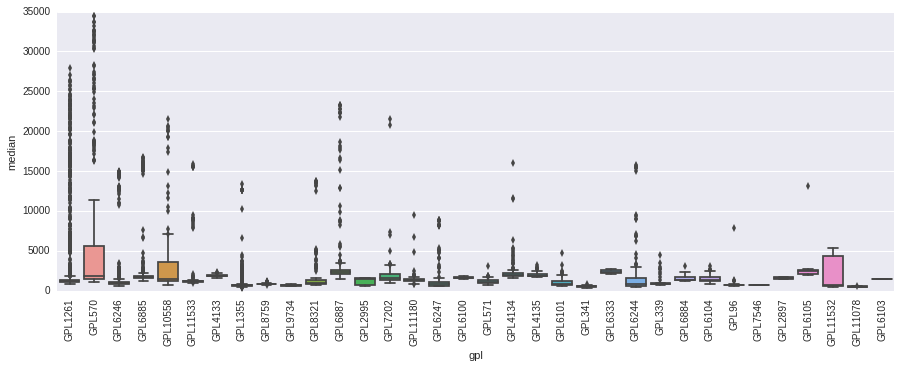

In [36]:
fig, ax = subplots(figsize=(15, 5))
sns.boxplot(data=res, x='gpl', y='median', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical');

In [27]:
tips = sns.load_dataset("tips")

In [28]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2
